# System Identification using the Ho-Kalman method

### Imports

Note, for SIMO systems, package slycot must be installed as well.
This method does not work for MISO/MIMO systems.

In [2]:
import numpy as np
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import control_matrices as cm
import control as ct 
from matrepr import mdisplay
from IPython.display import display, Math, Latex

### System
Here, the true state space system $\Sigma$ is created. In reality, we wouldn't know this system or the matrices
defining it. The system is defined as:
$$
    x[k+1] = Ax[k] + Bu \\
    y[k] = Cx[k] + Du
$$
where $A \in \mathbb{R}^{nxn}, B \in \mathbb{R}^{nxp}, C \in \mathbb{R}^{qxn}, D \in \mathbb{R}^{qxp}$,\
$x \in \mathbb{R}^{nx1}, u \in \mathbb{R}^{px1}$ and $y \in \mathbb{R}^{qx1}$.\
$n$ is the system order, $p$ the number of inputs and $q$ the number of outputs.

In [3]:
# %% System
A = np.array([[0,1,0,0],
              [-0.5,-0.4,0,-0.5],
              [0,0,0.2,-1],
              [0,0,0,-0.8]]
              )

B = np.array(
    [[0],
     [1],
     [0],
     [1]]
)
C = np.array(
    [[1,0,2,0]]
    )
D = np.array([[0.0]])


# This line will raise an error if state space is not
# appropriately dimensioned.
cm.check_state_space_dimensions(A, B, C, D)

mdisplay(A, title='A')
mdisplay(B, title='B')
mdisplay(C, title='C')
mdisplay(D, title='D')

# We will need the dimensions of the system later.
n = A.shape[0]
p = B.shape[1]
q = C.shape[0]

# Some sanity checks on the system.
poles = np.linalg.eigvals(A)

mdisplay(np.real_if_close(poles),title="Poles")
if np.all(np.abs(poles) < 1):
    display("A is stable.")
else:
    display("A is not stable.")


,0,1,2,3
0,0,1,0,0
1,-0.5,-0.4,0,-0.5
2,0,0,0.2,-1
3,0,0,0,-0.8


,0
0,0
1,1
2,0
3,1


,0,1,2,3
0,1,0,2,0


,0
0,0


0,1,2,3
-0.2+0.6782i,-0.2--0.6782i,0.2+0i,-0.8+0i


'A is stable.'

### Checking controllability and observability

In [4]:
ctr = cm.make_controllability_matrix(A, B)
ctr_rank = np.linalg.matrix_rank(ctr)
ctr_str = fr"=n={n}\rightarrow$ Controllable" if ctr_rank==n else fr"<n={n}\rightarrow$ Not Controllable"
mdisplay(ctr, title="'Controllability Matrix")
display(Latex(fr"$rank(\mathcal{{C}})={ctr_rank}" + ctr_str))

obs = cm.make_observability_matrix(A, C)
obs_rank = np.linalg.matrix_rank(obs)
obs_str = fr"=n={n}\rightarrow$ Observable" if obs_rank==n else fr"<n={n}\rightarrow$ Not Observable"
mdisplay(obs, title="'Observability Matrix")
display(Latex(fr"$rank(\mathcal{{O}})={obs_rank}" + obs_str))

,0,1,2,3
0,0,1,-0.9,0.26
1,1,-0.9,0.26,0.026
2,0,-1,0.6,-0.52
3,1,-0.8,0.64,-0.512


<IPython.core.display.Latex object>

,0,1,2,3
0,1,0,2,0
1,0,1,0.4,-2
2,-0.5,-0.4,0.08,0.7
3,0.2,-0.34,0.016,-0.44


<IPython.core.display.Latex object>

### Input-output data
Here, we're gathering $N$ input-output data samples from which to extract the markov parameters
$\mathcal{Y} = \left[ \begin{array}{cccc} D & CB & CAB & \cdots & CA^{N-2}B \end{array} \right]$ using $Y = \mathcal{Y}U$ where

$$
Y = \left[ \begin{array}{cccc} y[0] & y[1] & \cdots & y[N-1] \end{array} \right] \\
U = \left[ \begin{array}{cccc}
    u[0] & u[1] & \cdots & u[N-1] \\
      0  & u[0] & \cdots & u[N-2] \\
      0  &  0   & \cdots & u[N-3] \\
    \vdots&\vdots&\vdots &\vdots   \\
      0  &  0   & \cdots & u[0]
    \end{array} \right]
$$
and $Y \in \mathbb{R}^{qxN}, \mathcal{Y} \in \mathbb{R}^{qxpN}$ and $U \in \mathbb{R}^{pNxN}$.
\
\
The estimated markov parameters $\hat{\mathcal{Y}}$ are then found using least squares using $\hat{\mathcal{Y}} = YU^{\dagger}$
where $U^{\dagger}$ denotes the pseudo-inverse of $U$. \
For this, $U$ needs to be well conditioned such that the pseudo-inverse is well defined. \
$U, Y, \hat{\mathcal{Y}}$ and $\mathcal{Y}$ are shown after the cell, as well as the input-output response.

,0,1,2,3,4,5,6,,993,994,995,996,997,998,999
0,0,0,-1,0.3,-0.78,0.842,-0.5404,⋯,-3.725e-08,2.068e-07,-3.828e-07,-1.714e-07,3.604e-07,-8.568e-08,-7.078e-08


,0,1,2,3,4,5,6,,993,994,995,996,997,998,999
0,0,0,-1,0.3,-0.78,0.842,-0.5404,⋯,1.019e-96,-8.155e-97,6.524e-97,-5.219e-97,4.176e-97,-3.34e-97,2.672e-97


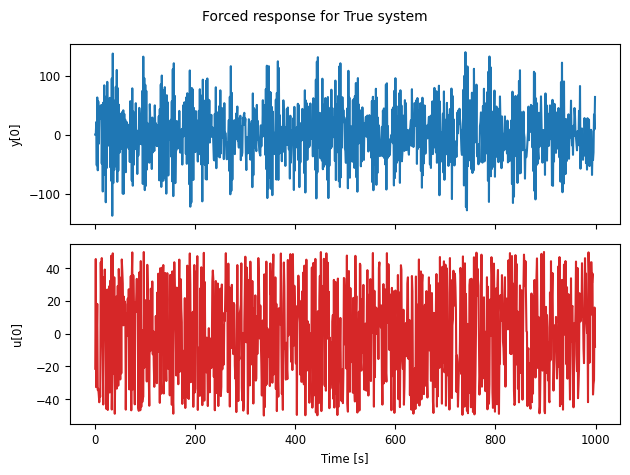

In [5]:
### Parameters for input data and system simulation.
# Whether to calculate rank and conditioning number for U.
# Might take a long time for large N.
calc_rank = True

# Nr of input samples.
N = 1000
# Input signal(s).
# Random noise usually makes for a well conditioned matrix.
u = np.random.uniform(-50, 50, size=(p,N))

true_sys = ct.ss(A,B,C,D,dt=True, name='True system')
resp = ct.forced_response(true_sys,U=u)
resp.plot()
plt.plot()

# Making U
u_interleaved = cm.interleave_vectors(*u)
U = cm.make_input_Toeplitz_matrix(u_interleaved, p)
rank_str = (f', rank: {np.linalg.matrix_rank(U)}, Conditioning Nr: {np.linalg.cond(U)}'
            if calc_rank else '.')
#mdisplay(U, title=f'U, shape: {U.shape}' + rank_str)

Y = resp.y
#mdisplay(Y, title=f'Y, shape: {Y.shape}')

# Markov Parameters
MP = Y@np.linalg.pinv(U)
mdisplay(np.where(np.isclose(0,MP),0,MP), title=f'Estimated Markov Parameters, shape: {MP.shape}, (q,p,N)={q,p,N}')

MP_true = cm.compute_markov_parameters(A,B,C,D,N)
mdisplay(MP_true, title=f'True Markov Parameters')

### Hankel Matrix
Constructing the markov parameter Hankel matrix and getting the extended Controllability and Observability Matrices.

Also, note that these estimated system matrices are not likely to be the same as the true
system matrices. If the input-output data is good however, they should be related to a
similar system $\hat{\Sigma}$ through the relations:
$$
  \hat{A} = T^{-1}AT, \hat{B} = T^{-1}B, \hat{C} = CT, \hat{D} = D
$$
where T is an invertible similarity matrix. $\hat{\Sigma}$ will have the same input-output relation and poles as the original system $\Sigma$.

In [6]:
H = cm.make_Hankel_matrix(MP[:,p:-p], int((N-p)/2), p, q)
H_shifted = cm.make_Hankel_matrix(MP[:,2*p:], int((N-q)/2), p, q)

# Taking the SVD of H
U_MP, s_MP ,Vh_MP = np.linalg.svd(H, full_matrices=False)
s_MP = np.where(s_MP < np.max(s_MP)/10, 0 ,s_MP)
S_MP = np.diag(s_MP)

# Extracting the observability matrix O and controllability Matrix Cr from the SVD of H.
O = U_MP@sqrtm(S_MP, 1/2)
O = O[:,~np.all(O == 0, axis=0)]
Cr = sqrtm(S_MP, 1/2)@Vh_MP
Cr = Cr[~np.all(Cr==0, axis=1),:]

mdisplay(O, title='Extended Observability Matrix')
mdisplay(Cr, title='Extended Controllability Matrix')

,0,1,2,3
0,-0.8098,0.8523,-0.05434,0.2712
1,0.8907,0.3697,0.5974,0.01449
2,-0.7326,0.1642,0.09758,-0.5847
3,0.7211,0.2127,-0.4649,0.03861
4,-0.5712,-0.327,0.263,0.3188
,⋮,⋮,⋮,⋮
494,6.498e-13,-1.556e-11,-3.933e-11,1.281e-12
495,-4.746e-12,-4.086e-12,9.966e-13,5.394e-11
496,-1.803e-12,1.319e-11,4.198e-11,3.216e-12
497,4.747e-12,5.69e-12,1.009e-12,-5.608e-11


,0,1,2,3,4,5,6,,493,494,495,496,497,498,499
0,-0.8098,0.8907,-0.7326,0.7211,-0.5712,0.3971,-0.2946,⋯,4.464e-12,6.498e-13,-4.746e-12,-1.803e-12,4.747e-12,2.539e-12,-4.657e-12
1,-0.8523,-0.3697,-0.1642,-0.2127,0.327,-0.1945,0.04186,⋯,1.159e-12,1.556e-11,4.086e-12,-1.319e-11,-5.69e-12,1.44e-11,1.193e-11
2,0.05434,-0.5974,-0.09758,0.4649,-0.263,-0.03143,0.06644,⋯,5.797e-12,3.933e-11,-9.966e-13,-4.198e-11,-1.009e-12,4.328e-11,4.428e-12
3,0.2712,0.01449,-0.5847,0.03861,0.3188,-0.202,-0.03875,⋯,-4.899e-11,1.281e-12,5.394e-11,3.216e-12,-5.608e-11,-7.423e-12,5.21e-11


### Extracting A,B,C and D matrices.

In [7]:
nhat = np.sum(s_MP != 0)
A_hat = np.linalg.pinv(O)@H_shifted@np.linalg.pinv(Cr)
B_hat = Cr[0:nhat,0:p]
C_hat = O[0:q,0:nhat]
D_hat = MP[0:q,0:p]

mdisplay(A_hat, title='A_hat')
mdisplay(B_hat, title='B_hat')
mdisplay(C_hat, title='C_hat')
mdisplay(D_hat, title='D_hat')

,0,1,2,3
0,-0.884,-0.2246,0.04556,-0.07028
1,0.2246,0.2308,0.4655,-0.06026
2,-0.04556,0.4655,-0.2129,-0.8333
3,-0.07028,0.06026,0.8333,-0.134


,0
0,-0.8098
1,-0.8523
2,0.05434
3,0.2712


,0,1,2,3
0,-0.8098,0.8523,-0.05434,0.2712


,0
0,9.02e-16


### Testing the estimated system

0,1,2,3
-0.8+0i,-0.2--0.6782i,-0.2+0.6782i,0.2+0i


0,1,2,3
-0.8+0i,-0.2--0.6782i,-0.2+0.6782i,0.2+0i


array([[list([<matplotlib.lines.Line2D object at 0x12ebf5790>])]],
      dtype=object)

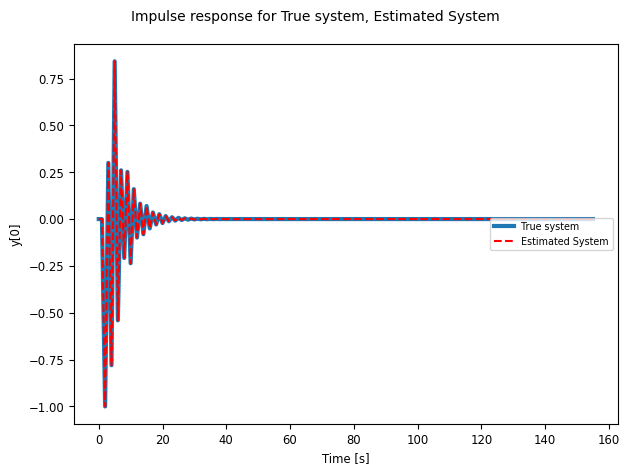

In [10]:
est_sys = ct.ss(A_hat, B_hat, C_hat, D_hat, dt=True, name='Estimated System')
truePoles = np.sort_complex(true_sys.poles())
estPoles = np.sort_complex(est_sys.poles())
mdisplay(truePoles, title='Poles of A')
mdisplay(estPoles, title='Poles of estimated A')

ct.impulse_response(true_sys).plot(linewidth=3)
ct.impulse_response(est_sys).plot(linestyle='--', color='r')
